In [1]:
import sys
import platform

In [2]:
if platform.system() == 'Windows':
    sys.path.append(r"D:\Pycharm_Projects")
    project_dir = r"D:\Pycharm_Projects\xgboost_loan_data"
else:
    # macOS
    sys.path.append(r"/Users/lukelee/Documents/Interview/Learning")
    project_dir = r"/Users/lukelee/Documents/Interview/Learning/xgboost_loan_data"


In [3]:
from xgboost_loan_data.code.bank_loan_predict import XgboostModel, LogisticRegressionModel, prob_to_boolean

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
print("Use Xgboost model")
M1 = XgboostModel(project_dir)
M1.prepare_data()
M1.fit_model()
prediction_model1 = M1.predict_with_test_data()


Use Xgboost model
Train size: 75.0%, Test size: 25.0%
Prediction Accuracy: 92.10%


In [6]:
print("Use Logistic model")
M2 = LogisticRegressionModel(project_dir)
#M2.remove_variable(["previous_loan_defaults_on_file","credit_score"])
M2.prepare_data()
M2.fit_model()
prediction_model2 = M2.predict_with_test_data()

Use Logistic model
using pandas's get_dummies function for categorical data
Train size: 75.0%, Test size: 25.0%


/Users/lukelee/Documents/Interview/Learning/xgboost_loan_data/env/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Prediction Accuracy: 89.20%


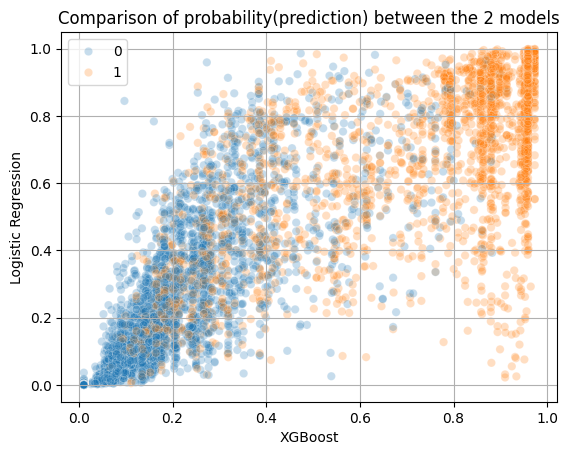

In [7]:
fig, ax = plt.subplots()
sns.scatterplot(x=prediction_model1,y=prediction_model2,
                alpha=0.25,
                hue=M1.test_data[1].iloc[:,0].tolist())
plt.xlabel("XGBoost")
plt.ylabel("Logistic Regression")
#plt.xlim([0,1])
#plt.ylim([0,1])
plt.title("Comparison of probability(prediction) between the 2 models")

plt.grid(True)
handles, labels = ax.get_legend_handles_labels()

plt.show()

In [8]:
M1_prediction = prob_to_boolean(prediction_model1)
M2_prediction = prob_to_boolean(prediction_model2)
y_test = M1.test_data[1].iloc[:,0].tolist()

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


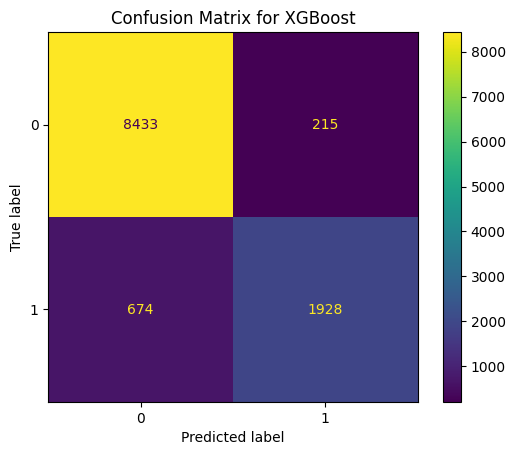

In [10]:
cfm_1 = confusion_matrix(y_true=y_test,y_pred=M1_prediction)
disp_cfm1 = ConfusionMatrixDisplay(confusion_matrix=cfm_1)

disp_cfm1.plot()
plt.title("Confusion Matrix for XGBoost")
plt.show()

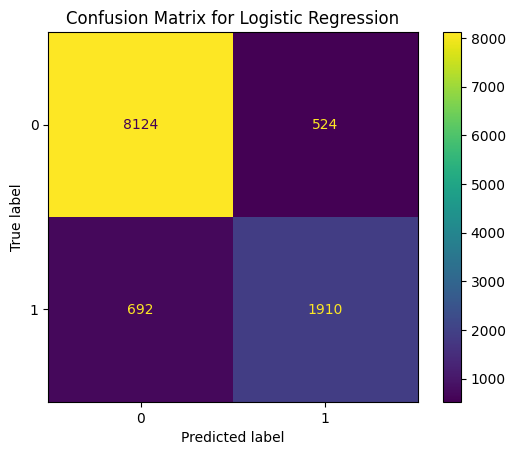

In [11]:
cfm_2 = confusion_matrix(y_true=y_test,y_pred=M2_prediction)
disp_cfm2 = ConfusionMatrixDisplay(confusion_matrix=cfm_2)

disp_cfm2.plot()
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

In [12]:
categorical_columns = M1.test_data[0].select_dtypes(exclude=np.number).columns.tolist()
categorical_columns

['person_gender',
 'person_education',
 'person_home_ownership',
 'loan_intent',
 'previous_loan_defaults_on_file']

In [13]:
test_cat_col = lambda x: '_'.join(x.split('_')[0:-1]) in categorical_columns

In [14]:
lg_coef = pd.DataFrame(M2.model.coef_,columns = M2.x.columns).T
lg_coef = lg_coef.sort_values(0)
lg_coef.loc[:,'IS_CATEGORY'] = list(map(test_cat_col,lg_coef.index))
lg_coef.head(10)

,0,IS_CATEGORY
previous_loan_defaults_on_file_Yes,-4.852567,True
person_home_ownership_OWN,-1.801025,True
loan_intent_VENTURE,-0.989493,True
person_gender_female,-0.936416,True
person_gender_male,-0.911104,True
loan_intent_EDUCATION,-0.696911,True
loan_amnt,-0.640701,False
loan_intent_PERSONAL,-0.477696,True
credit_score,-0.444177,False
person_education_Associate,-0.428898,True


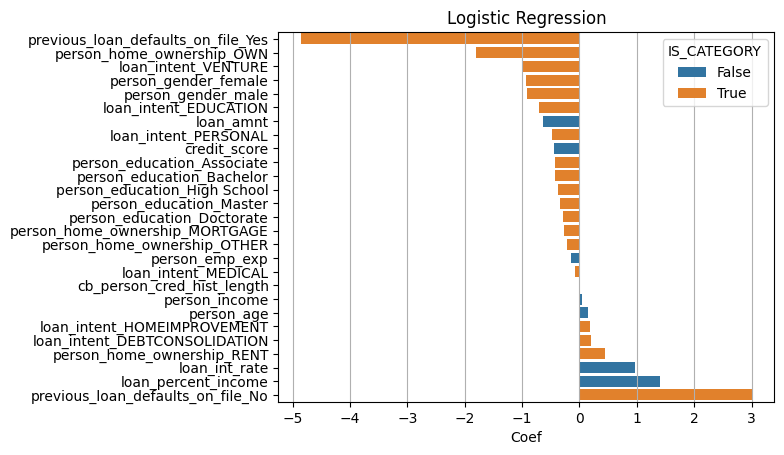

In [15]:
plt.figure()

sns.barplot(x=lg_coef.iloc[:,0].tolist(),y=lg_coef.index,hue=lg_coef.IS_CATEGORY)
plt.ylabel(None)
plt.xlabel('Coef')
plt.title("Logistic Regression")
plt.grid(axis='x')
plt.show()

In [16]:
xgb_score = M1.model.get_score()
xgb_score = pd.DataFrame.from_dict(xgb_score.items())
xgb_score.columns=['variable','Score']
xgb_score = xgb_score.sort_values('Score',ascending=False).reset_index(drop=True)

xgb_score.loc[:,'IS_CATEGORY'] = [ x in categorical_columns for x in xgb_score.variable.tolist()]
xgb_score


,variable,Score,IS_CATEGORY
0,person_income,33.0,False
1,loan_int_rate,26.0,False
2,loan_percent_income,24.0,False
3,person_home_ownership,21.0,True
4,loan_intent,20.0,True
5,credit_score,10.0,False
6,previous_loan_defaults_on_file,10.0,True
7,person_age,2.0,False
8,loan_amnt,1.0,False
9,cb_person_cred_hist_length,1.0,False


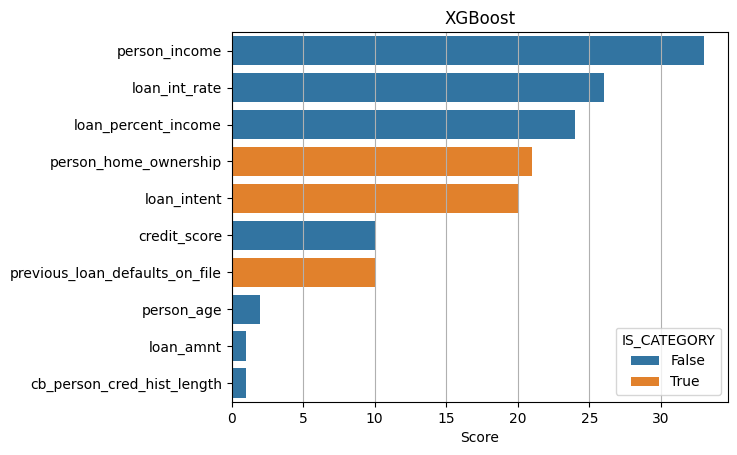

In [17]:
plt.figure()

sns.barplot(y=xgb_score.iloc[:,0].tolist(),x=xgb_score.Score,hue=xgb_score.IS_CATEGORY)
plt.ylabel(None)
plt.grid(axis='x')
plt.xlabel('Score')
plt.title("XGBoost")
plt.show()

In [18]:
from xgboost import plot_tree


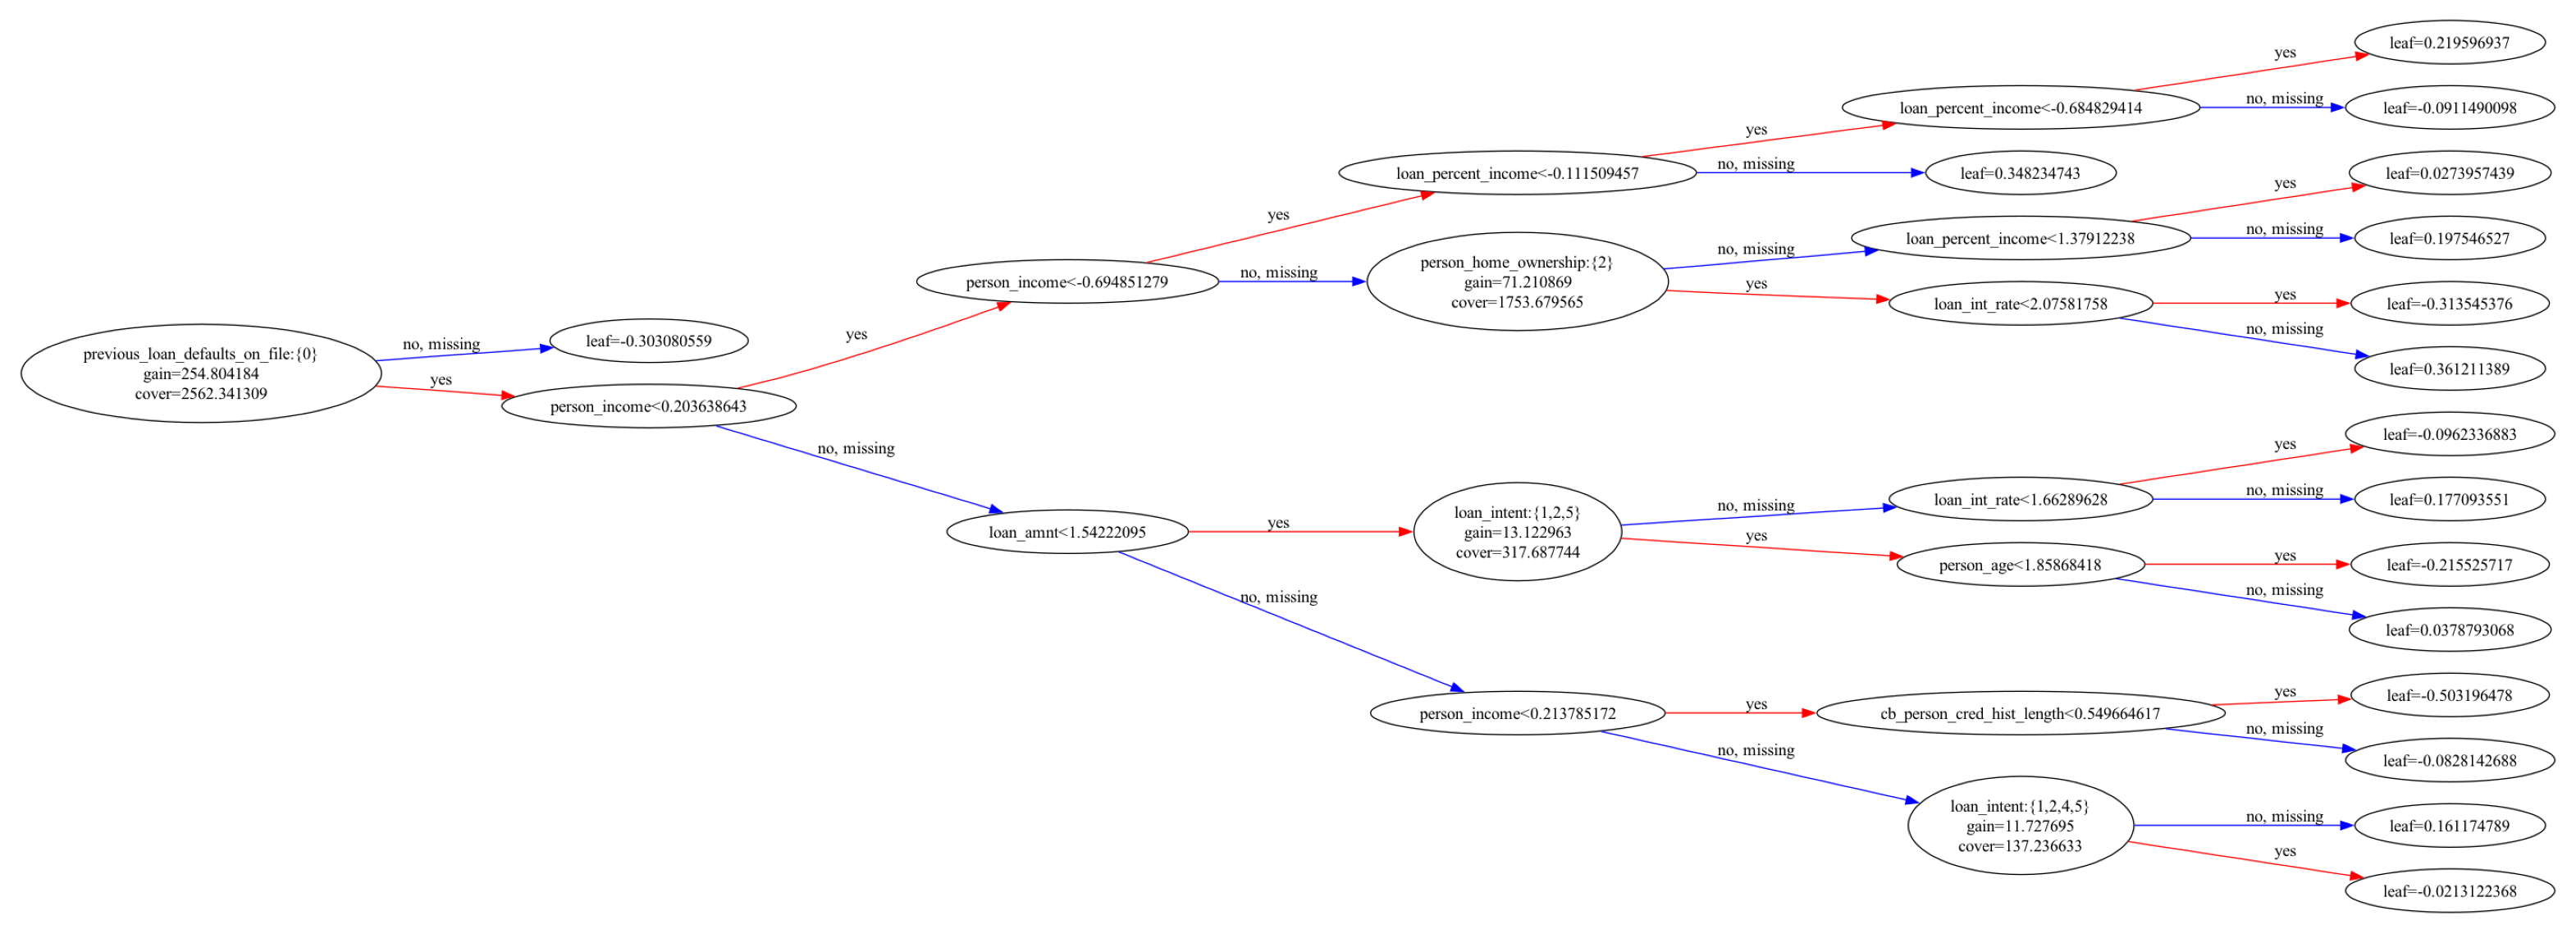

In [38]:
fig, ax = plt.subplots(figsize=(20,20),dpi=200)
plot_tree(M1.model,tree_idx=9,rankdir='LR',ax=ax)
plt.show()